## Import the necesssary libraries

In [1]:
!pip install nsepy

  Preparing metadata (setup.py) ... - done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36084 sha256=85d9706e91a54d7187279eb949326c135106383d38f3958caddde39f592ec9fd
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

from nsepy import get_history

from statsmodels.tsa.stattools import adfuller
#from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima

## Load the Datasets

In [4]:
nifty = get_history(symbol="NIFTY",
                    start=date(2000,1,1),
                    end=date.today(),
                    index=True)
nifty.tail()

,Open,High,Low,Close,Volume,Turnover
Date,,,,,,
2022-12-19,18288.10,18431.65,18244.55,18420.45,154847475,1.445523e+11
2022-12-20,18340.30,18404.90,18202.65,18385.30,169041783,1.503856e+11
2022-12-21,18435.15,18473.35,18162.75,18199.10,187594274,1.722344e+11
2022-12-22,18288.80,18318.75,18068.60,18127.35,195699650,1.672523e+11
2022-12-23,17977.65,18050.45,17779.50,17806.80,221454773,1.848694e+11


In [5]:
from nsepy import get_index_pe_history
nifty_pe = get_index_pe_history(symbol="NIFTY",
                                start=date(2000,1,1),
                                end=date.today())
nifty_pe.tail()

,P/E,P/B,Div Yield
Date,,,
2022-12-19,22.14,4.32,1.28
2022-12-20,22.10,4.32,1.28
2022-12-21,21.87,4.27,1.29
2022-12-22,21.79,4.26,1.27
2022-12-23,21.40,4.18,1.29


In [6]:
type(nifty.index)

pandas.core.indexes.base.Index

In [7]:
nifty.index=pd.to_datetime(nifty.index)

In [8]:
df=pd.merge(nifty, nifty_pe, left_index=True, right_index=True)
df.tail()

,Open,High,Low,Close,Volume,Turnover,P/E,P/B,Div Yield
Date,,,,,,,,,
2022-12-19,18288.10,18431.65,18244.55,18420.45,154847475,1.445523e+11,22.14,4.32,1.28
2022-12-20,18340.30,18404.90,18202.65,18385.30,169041783,1.503856e+11,22.10,4.32,1.28
2022-12-21,18435.15,18473.35,18162.75,18199.10,187594274,1.722344e+11,21.87,4.27,1.29
2022-12-22,18288.80,18318.75,18068.60,18127.35,195699650,1.672523e+11,21.79,4.26,1.27
2022-12-23,17977.65,18050.45,17779.50,17806.80,221454773,1.848694e+11,21.40,4.18,1.29


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5715 entries, 2000-01-03 to 2022-12-23
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5715 non-null   float64
 1   High       5715 non-null   float64
 2   Low        5715 non-null   float64
 3   Close      5715 non-null   float64
 4   Volume     5715 non-null   int64  
 5   Turnover   5715 non-null   float64
 6   P/E        5715 non-null   float64
 7   P/B        5715 non-null   float64
 8   Div Yield  5715 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 446.5 KB


In [10]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

## EDA

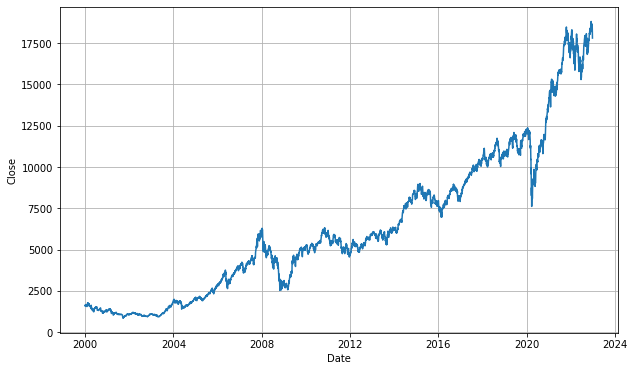

In [11]:
#plot close price
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Date", y="Close")
plt.grid(True)
#plt.xlabel('Date')
#plt.ylabel('Close Prices')
#plt.plot(df['Close'])
#plt.title('nifty - 50 closing price')
plt.show()

### Probability distribution to visualize the data in our series.

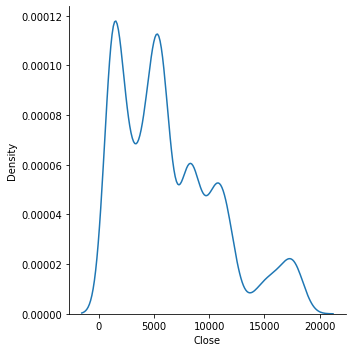

In [12]:
#nifty['Close'].plot(kind='kde')
sns.displot(nifty, x="Close", kind="kde")

plt.show()

## ADF (Augmented Dickey-Fuller) Test

In [13]:
# Test of stationarity
result = adfuller(df[['P/E']].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.025915
p-value: 0.032544


In [14]:
# Test of stationarity
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df[['Close']].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.109849
p-value: 0.995300


* **p-value: 0.994420 > 0.05**
* Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

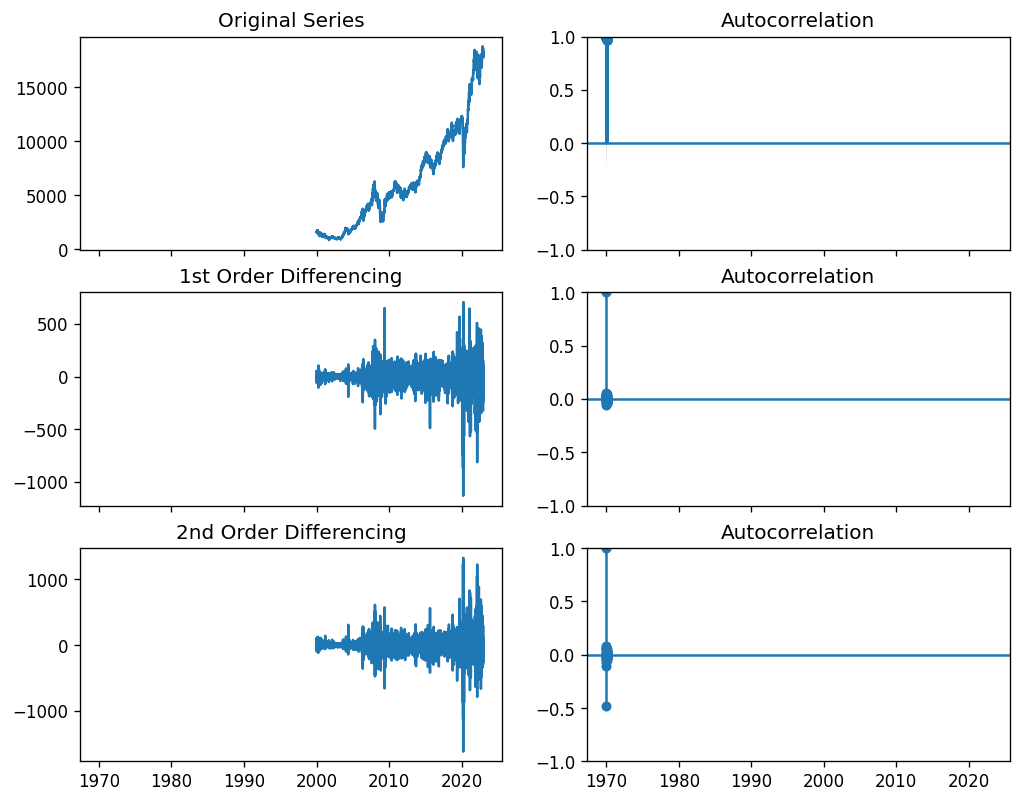

In [15]:
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df[['Close']]); axes[0, 0].set_title('Original Series')
plot_acf(df[['Close']], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df[['Close']].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df[['Close']].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df[['Close']].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df[['Close']].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

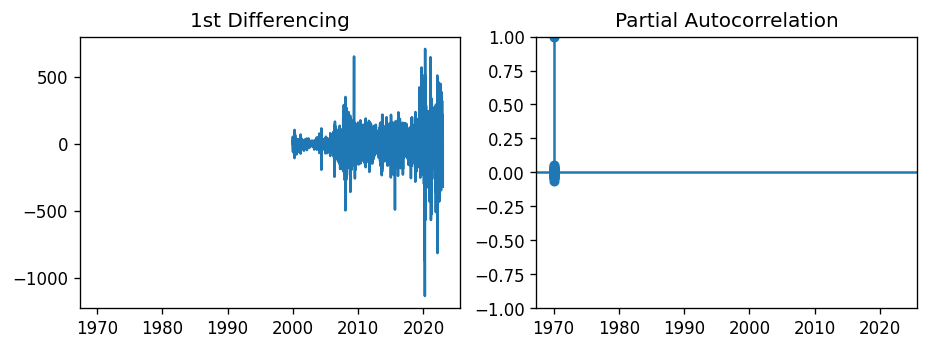

In [16]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df[['Close']].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df[['Close']].diff().dropna(), ax=axes[1], method='ywm')

plt.show()

In [17]:
df_close = df['Close']

In [18]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

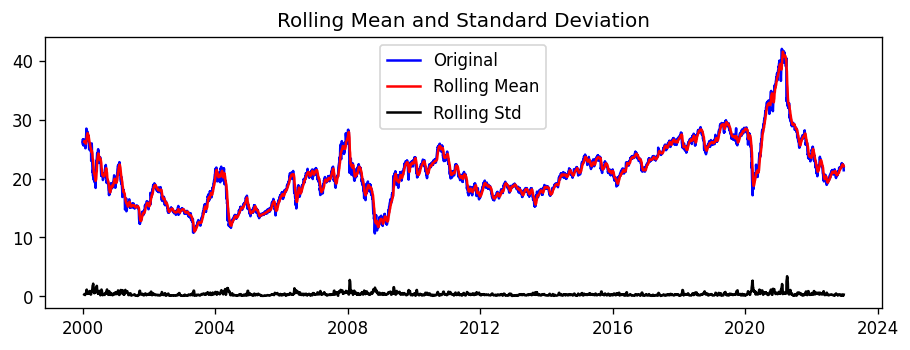

Results of dickey fuller test
Test Statistics                  -3.025915
p-value                           0.032544
No. of lags used                 21.000000
Number of observations used    5693.000000
critical value (1%)              -3.431499
critical value (5%)              -2.862048
critical value (10%)             -2.567040
dtype: float64


In [19]:
test_stationarity(df[['P/E']])

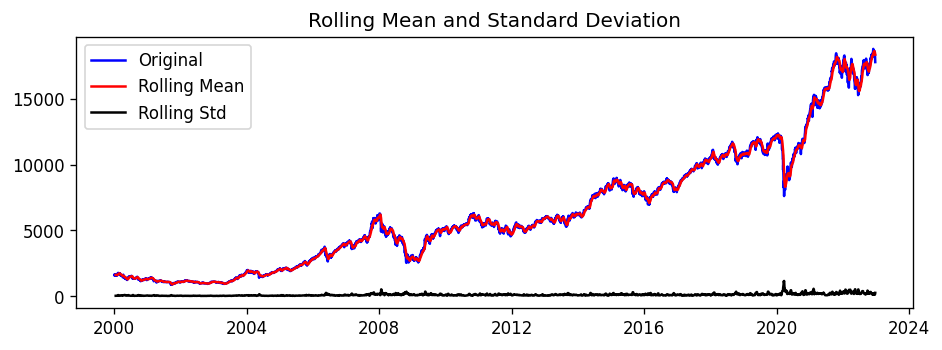

Results of dickey fuller test
Test Statistics                   1.109849
p-value                           0.995300
No. of lags used                 33.000000
Number of observations used    5681.000000
critical value (1%)              -3.431502
critical value (5%)              -2.862049
critical value (10%)             -2.567041
dtype: float64


In [20]:
test_stationarity(df[['Close']])

* The mean and standard deviation is increasing as shown in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

<Figure size 1080x360 with 0 Axes>

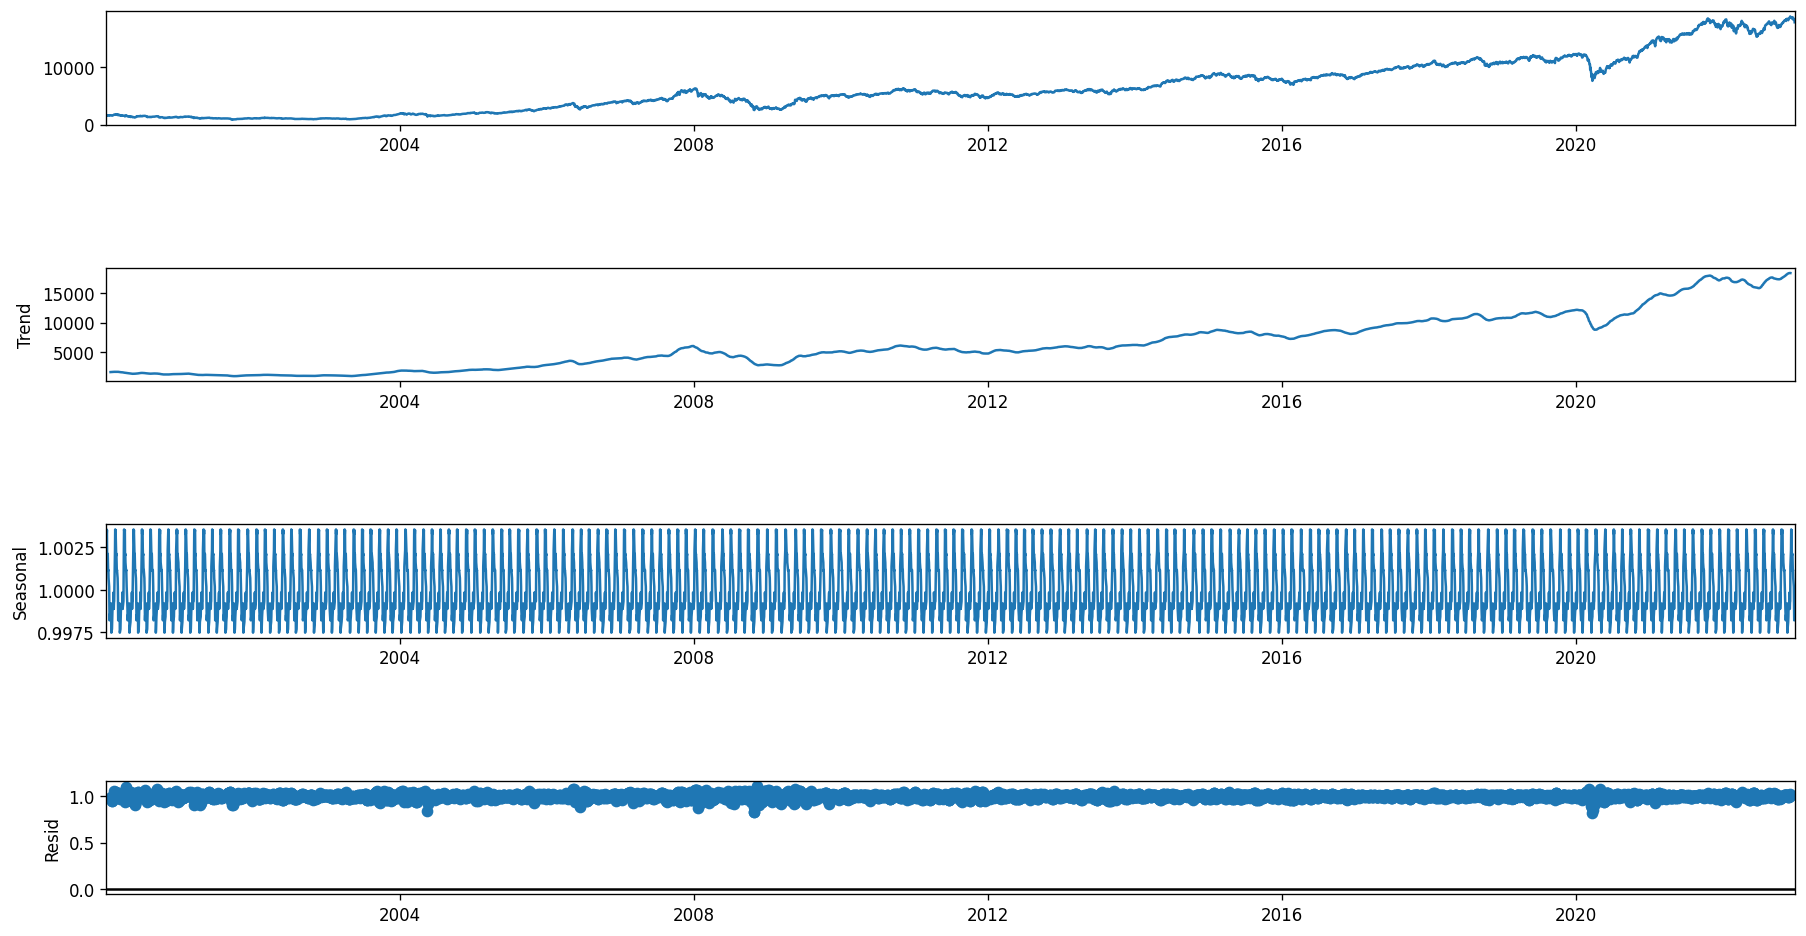

In [21]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df[['Close']], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

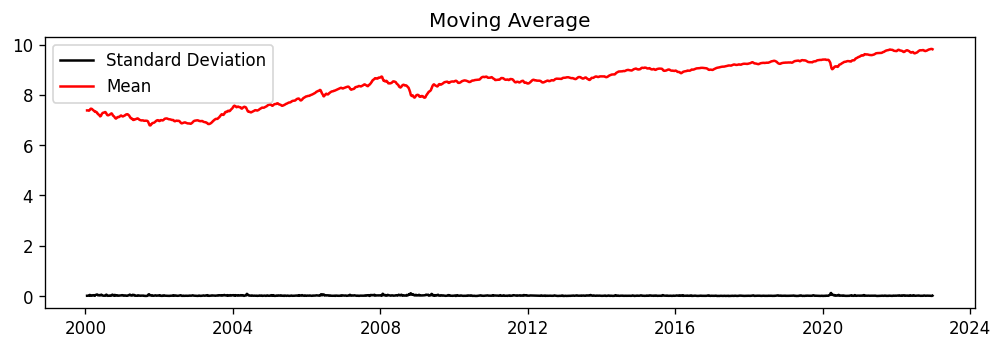

In [22]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 3
df_log = np.log(df[['Close']])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
#plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend(loc='best')
plt.show()

In [23]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

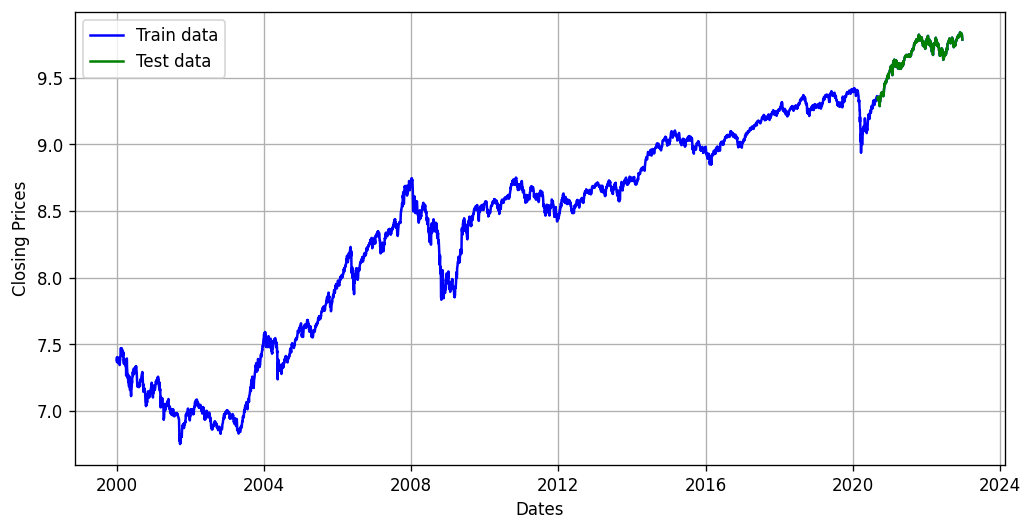

In [24]:
plt.figure(figsize=(10,5))

plt.plot(df_log, 'blue', label='Train data')
plt.plot(test_data, 'green', label='Test data')

plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')

plt.legend()
plt.show()

## Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

In [25]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28836.316, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28850.456, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28851.588, Time=3.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28834.807, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28854.750, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28852.573, Time=3.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28852.556, Time=2.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-28854.567, Time=1.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28854.508, Time=1.96 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28849.920, Time=2.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-28853.492, Time=0.92 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.502 seconds


In [26]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5140
Model:               SARIMAX(1, 1, 1)   Log Likelihood               14431.375
Date:                Sat, 24 Dec 2022   AIC                         -28854.750
Time:                        14:38:34   BIC                         -28828.571
Sample:                             0   HQIC                        -28845.587
                               - 5140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.766      0.077   -5.89e-05       0.001
ar.L1         -0.4204      0.093     -4.542      0.000      -0.602      -0.239
ma.L1          0.4790      0.091      5.267      0.000       0.301       0.657
sigma2         0.0002    1.7e-06    125.124      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23290.42
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

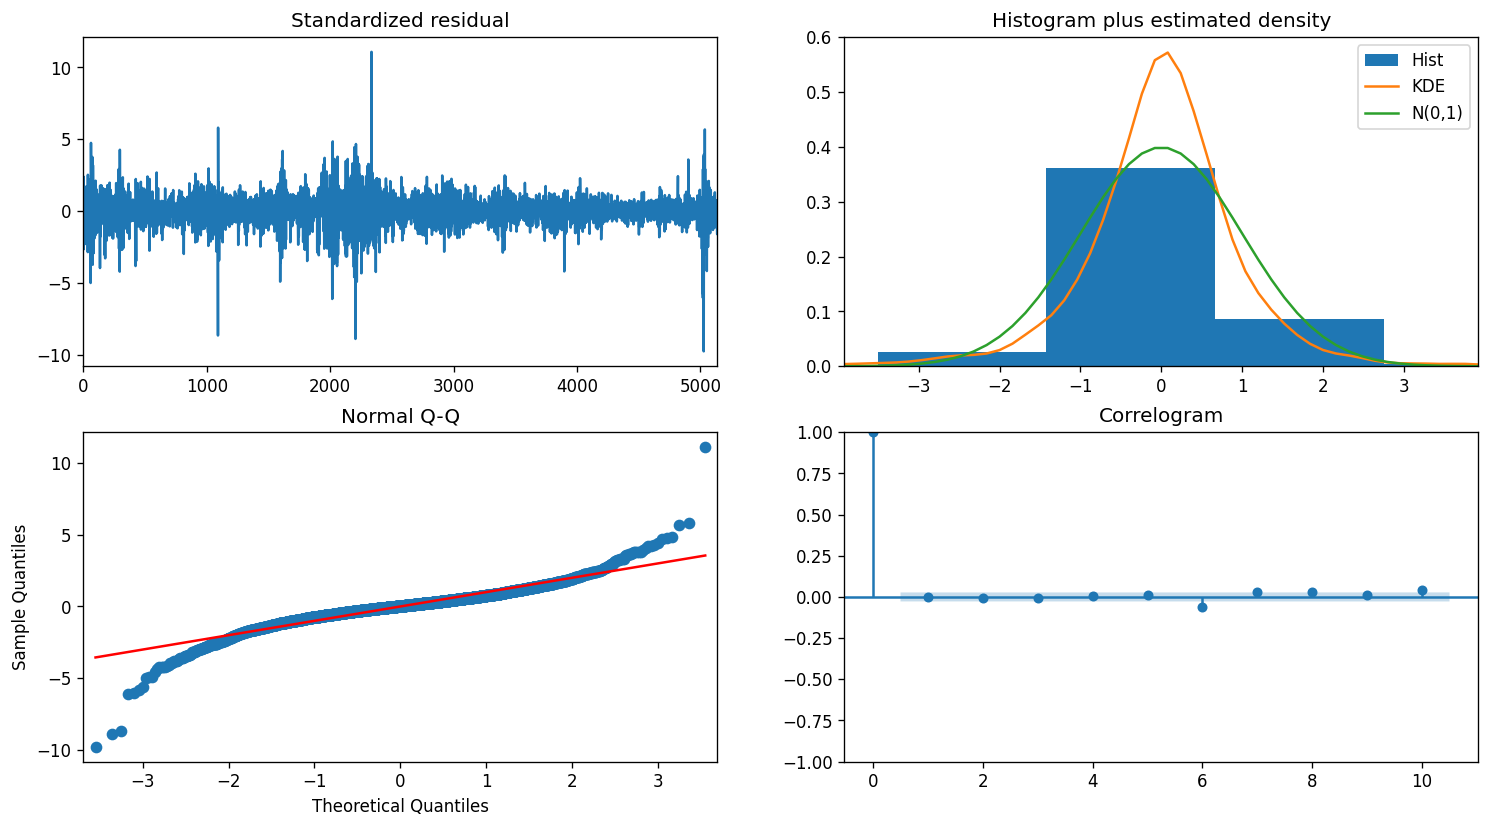

In [27]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

As a result, the Auto ARIMA model assigned the values 2, 1, and 0 to, p, d, and q, respectively.

In [28]:
train_data.shape, test_data.shape

((5140, 1), (572, 1))

In [29]:
y_train = train_data.asfreq('B')

In [30]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(y_train, order=(2, 1, 0))
res = mod.fit()

In [31]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5390
Model:                 ARIMA(2, 1, 0)   Log Likelihood               14356.157
Date:                Sat, 24 Dec 2022   AIC                         -28706.314
Time:                        14:38:36   BIC                         -28686.537
Sample:                    01-06-2000   HQIC                        -28699.408
                         - 09-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0388      0.007      5.328      0.000       0.025       0.053
ar.L2         -0.0261      0.008     -3.445      0.001      -0.041      -0.011
sigma2         0.0002   1.62e-06    127.450      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):             30279.37
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
test_data = test_data.asfreq('B')
test_data.isnull().sum()

Close    31
dtype: int64

In [33]:
predictions =res.get_forecast(steps=7, exog=test_data['Close'][:7])
predictions.summary_frame()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-09-03,9.353170,0.014348,9.325048,9.381292
2020-09-04,9.353025,0.020689,9.312475,9.393574
2020-09-07,9.353018,0.025294,9.303443,9.402593
2020-09-08,9.353022,0.029167,9.295856,9.410188
2020-09-09,9.353022,0.032586,9.289154,9.416890
2020-09-10,9.353022,0.035680,9.283090,9.422954
2020-09-11,9.353022,0.038526,9.277512,9.428532


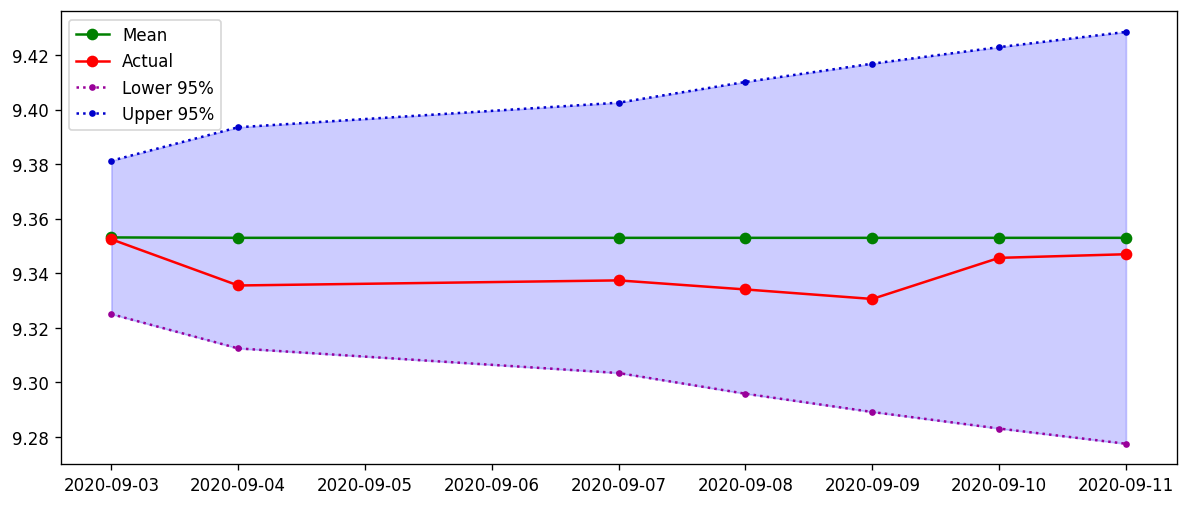

In [34]:
plt.figure(figsize=(12,5))
predicted, = plt.plot(test_data['Close'][:7].index, 
                      predictions.summary_frame()['mean'], 'go-', label='Mean')

actual,  = plt.plot( test_data['Close'][:7], 'ro-', label='Actual')
 
lower, = plt.plot(test_data['Close'][:7].index, 
                  predictions.summary_frame()['mean_ci_lower'], 
                  color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(test_data['Close'][:7].index, 
                  predictions.summary_frame()['mean_ci_upper'], 
                  color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
 
plt.fill_between(test_data['Close'][:7].index, 
                 predictions.summary_frame()['mean_ci_lower'], 
                 predictions.summary_frame()['mean_ci_upper'], 
                 color = 'b', alpha = 0.2)

plt.legend(handles=[predicted, actual, lower, upper])

plt.show()

In [35]:
predict = res.get_forecast(len(test_data.index), exog=test_data)
predict.summary_frame()
#res.get_forecast(exog=test_data)

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-09-03,9.353170,0.014348,9.325048,9.381292
2020-09-04,9.353025,0.020689,9.312475,9.393574
2020-09-07,9.353018,0.025294,9.303443,9.402593
2020-09-08,9.353022,0.029167,9.295856,9.410188
2020-09-09,9.353022,0.032586,9.289154,9.416890
...,...,...,...,...
2022-12-19,9.353022,0.355386,8.656479,10.049565
2022-12-20,9.353022,0.355683,8.655897,10.050147
2022-12-21,9.353022,0.355979,8.655315,10.050729
2022-12-22,9.353022,0.356276,8.654734,10.051310


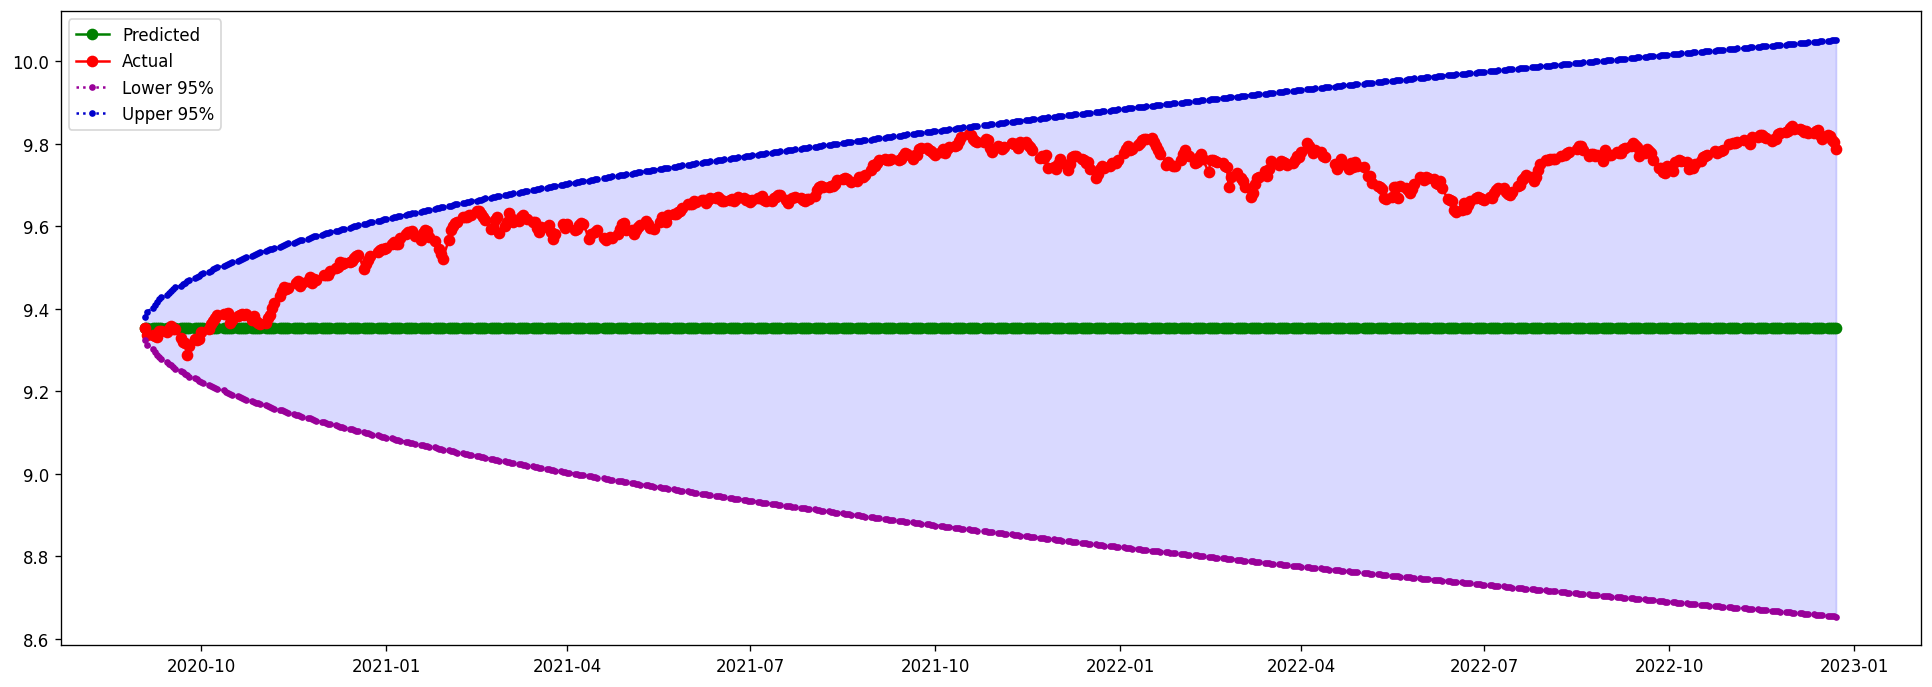

In [36]:
plt.figure(figsize=(20,7))
#Train, = plt.plot(train_data.index, train_data['Close'], 'go-', label='Train')
predicted, = plt.plot(test_data.index, predict.summary_frame()['mean'].values, 'go-', label='Predicted')

actual,  = plt.plot( test_data[['Close']], 'ro-', label='Actual')
 
lower, = plt.plot(test_data.index, predict.summary_frame()['mean_ci_lower'].values, color='#990099',
                  marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(test_data.index, predict.summary_frame()['mean_ci_upper'].values, 
                  color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
 
plt.fill_between(test_data.index, predict.summary_frame()['mean_ci_lower'].values, predict.summary_frame()['mean_ci_upper'].values, 
                 color = 'b', alpha = 0.15)
plt.legend(handles=[predicted, actual, lower, upper])
plt.show()

In [37]:
predict.summary_frame().index

DatetimeIndex(['2020-09-03', '2020-09-04', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-14',
               '2020-09-15', '2020-09-16',
               ...
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23'],
              dtype='datetime64[ns]', length=602, freq='B')

In [38]:
test_data.index

DatetimeIndex(['2020-09-03', '2020-09-04', '2020-09-07', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-14',
               '2020-09-15', '2020-09-16',
               ...
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23'],
              dtype='datetime64[ns]', name='Date', length=602, freq='B')

In [39]:
test_data['pred_close']=predict.summary_frame()['mean'].values
test_data.isnull().sum()

Close         31
pred_close     0
dtype: int64

In [40]:
test_data=test_data.dropna()
test_data.shape

(571, 2)

In [41]:
# report performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
mse = mean_squared_error(test_data['Close'], test_data['pred_close'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data['Close'], test_data['pred_close'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['Close'], test_data['pred_close']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_data['pred_close'] - test_data['Close'])/np.abs(test_data['Close']))
print('MAPE: '+str(mape))

MSE: 0.11866248498135615
MAE: 0.32087016293769116
RMSE: 0.34447421526343036
MAPE: 0.03300465189325954
